This is the import section

In [19]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from imblearn.over_sampling import SMOTE
from sklearn.discriminant_analysis import StandardScaler 
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline  
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score 
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
import joblib
from sklearn.svm import SVC 
from sklearn.model_selection import train_test_split 
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler 
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import joblib
import plotly.express as px 
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import seaborn as sns
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats 




Fetch data frame

In [3]:
pd.set_option('display.max_columns', None)
df_raw = pd.read_csv("./data/raw_database.csv", dtype={'Flight Phase':'str', 'Visibility':'str',
                                                       'Precipitation':'str','Species ID':'str',
                                                       'Species Name':'str', 'Species Quantity':'str',
                                                       'Flight Impact': 'str', 'Height':'Int64', 
                                                       'Speed':'float64','Distance':'float64',  
                                                       'Fatalities':'Int64', 'Injuries': 'Int64'}, low_memory=False)
df=df_raw.copy() 
df_raw.head(3)

,Record ID,Incident Year,Incident Month,Incident Day,Operator ID,Operator,Aircraft,Aircraft Type,Aircraft Make,Aircraft Model,Aircraft Mass,Engine Make,Engine Model,Engines,Engine Type,Engine1 Position,Engine2 Position,Engine3 Position,Engine4 Position,Airport ID,Airport,State,FAA Region,Warning Issued,Flight Phase,Visibility,Precipitation,Height,Speed,Distance,Species ID,Species Name,Species Quantity,Flight Impact,Fatalities,Injuries,Aircraft Damage,Radome Strike,Radome Damage,Windshield Strike,Windshield Damage,Nose Strike,Nose Damage,Engine1 Strike,Engine1 Damage,Engine2 Strike,Engine2 Damage,Engine3 Strike,Engine3 Damage,Engine4 Strike,Engine4 Damage,Engine Ingested,Propeller Strike,Propeller Damage,Wing or Rotor Strike,Wing or Rotor Damage,Fuselage Strike,Fuselage Damage,Landing Gear Strike,Landing Gear Damage,Tail Strike,Tail Damage,Lights Strike,Lights Damage,Other Strike,Other Damage
0,127128,1990,1,1,DAL,DELTA AIR LINES,B-757-200,A,148,26,4.0,34.0,40,2.0,D,1,1.0,NaN,NaN,KCVG,CINCINNATI/NORTHERN KENTUCKY INTL ARPT,KY,ASO,NaN,CLIMB,NaN,NaN,<NA>,NaN,NaN,NE1,GULL,1,NaN,<NA>,<NA>,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
1,129779,1990,1,1,HAL,HAWAIIAN AIR,DC-9,A,583,90,4.0,34.0,10,2.0,D,5,5.0,NaN,NaN,PHLI,LIHUE ARPT,HI,AWP,NaN,TAKEOFF RUN,NaN,NaN,0,NaN,0.0,ZZ201,HOUSE SPARROW,1,NaN,<NA>,<NA>,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,129780,1990,1,2,UNK,UNKNOWN,UNKNOWN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PHLI,LIHUE ARPT,HI,AWP,NaN,NaN,NaN,NaN,<NA>,NaN,0.0,R1101,BARN OWL,1,NaN,<NA>,<NA>,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Remove rows where there is no animal invoved or where the species ID and the species name is not known.

In [4]:
no_of_null_id= df[df['Species ID'].isnull()]['Species ID'].count()
no_of_null_name = df[df['Species Name'].isnull()]
df=df.drop(no_of_null_name.index)
print(f"Number of null ID {no_of_null_id} and Name {no_of_null_name.shape[0]}")

Number of null ID 0 and Name 80


Checking if some entried had same ID but different animal name and such.

In [5]:
species_map = df.dropna(subset=["Species Name"]).set_index("Species ID")["Species Name"].to_dict()
df["New Species Name"] = df.apply(lambda row: species_map.get(row["Species ID"], row["Species Name"]), axis=1)
mismatched = df[df["Species Name"] != df["New Species Name"]] 
print(f"There are {mismatched.shape[0]} mismatched entries")
df=df.drop("New Species Name",axis=1)

There are 0 mismatched entries


Unknown animals are dropped. These aren't null rather the Animals with unknown name. Their ID starts with UNK.

In [6]:
df[df['Species ID'].str.startswith('UNK')].groupby(['Species Name']).count()
no_of_rows_unknown_name = df[df['Species ID'].str.startswith('UNK')]['Species ID'].count() 
print(f"Number of unknown animals {no_of_rows_unknown_name}.") 
df = df[~df['Species ID'].str.startswith('UNK')]

Number of unknown animals 80771.


In [7]:
category_map = {  
    'SMALL BIRD': [
        'SPARROW', 'FINCH', 'WARBLER', 'WREN', 'VIREO', 'CHICKADEE', 'TITMOUSE','BUDGERIGAR',
        'SWIFT', 'HUMMINGBIRD', 'NUTHATCH', 'WAXWING', 'JUNCO', 'BUNTING',
        'KINGLET', 'BUSHTIT', 'PIPIT', 'VERDIN', 'GNATCATCHER', 'TOWHEE',
        'PHOEBE', 'VIREOS', 'MYNA', 'BULBUL',  'PINE SISKIN',
        'LONGSPUR', 'CHAT', 'UNKNOWN SMALL BIRD',  'MUNIA', 'SWALLOW',
        'WAXBILL', 'TANAGER','CANARY', 'DRONGO', 'WHITE-EYE', 'ELAENIA',
        'HORNED LARK', 'ROSE-BREASTED GROSBEAK', 'NORTHERN PARULA', 'AMERICAN REDSTART',
        'VEERY', 'EURASIAN SKYLARK', 'BOBOLINK', 'DICKCISSEL', 'RED AVADAVAT', 
        'CHUCK-WILL\'S-WIDOW', 'LARKS', 'RED-NAPED SAPSUCKER', 'DOWNY WOODPECKER',
        'HAIRY WOODPECKER', 'RED-BREASTED SAPSUCKER', 'COMMON YELLOWTHROAT',
        'WHITE-WINGED CROSSBILL', 'PINE GROSBEAK', 'EVENING GROSBEAK',
        'BLACK-HEADED GROSBEAK', 'BLUE GROSBEAK', 'RED CROSSBILL', 'REDWING',
        'COMMON REDPOLL', 'HOARY REDPOLL', 'ROADRUNNER'
    ],
    'MEDIUM BIRD':[
        'UNKNOWN MEDIUM BIRD','DOVE', 'CUCKOO', 'SHRIKE', 'KINGBIRD', 'MOCKINGBIRD','RED-LEGGED PARTRIDGE',
        'THRASHER', 'JAY', 'MARTIN', 'ROBIN', 'THRUSH', 'CARDINAL', 'COWBIRD', 'ORIOLE', 'CROW', 'RAVEN', 'JAY', 'MAGPIE', 'STARLING', 'ROOK', 'GRACKLE',
        'BLACKBIRD', 'BOAT-TAILED', 'RED-WINGED','WHIP-POOR-WILL', 'BELTED KINGFISHER', 'YELLOW-BELLIED SAPSUCKER',
        'RED-BELLIED WOODPECKER', 'WOODPECKERS, PICULETS', 'WOODPECKERS',
        'RED-HEADED WOODPECKER', 'MONK PARAKEET', 'NANDAY PARAKEET',
        'OLIVE-THROATED PARAKEET', 'PARROTS', 'GREAT KISKADEE', 'SCALED QUAIL',
        'CHUKAR', 'QUAILS', 'EURASIAN THICK-KNEE', 'DOUBLE-STRIPED THICK-KNEE',
        'COMMON PAURAQUE', 'GREATER ROADRUNNER'
    ],
    'LARGE BIRD': [
        'GOOSE', 'GEESE', 'DUCK', 'HERON', 'EGRET', 'CORMORANT', 'PELICAN', 'NORTHERN FULMAR',
        'CRANE', 'SWAN', 'TURKEY', 'IBIS', 'LOON', 'RAIL', 'GALLINULE',
        'BITTERN', 'PHALAROPE', 'MOORHEN', 'AVOCET', 'GODWIT', 'CURLEW',
        'SPOONBILL', 'JAEGER', 'SHEARWATER', 'ALBATROSS', 'STORK', 'PETREL',
         'PHEASANT', 'GROUSE', 'GUINEAFOWL', 'FRANCOLIN', 'PTARMIGAN','UNKNOWN LARGE BIRD'
        'PARTRIDGE', 'TURKEY','DOWITCHER', 'DUNLIN',
        'SKIMMER', 'TROPICBIRD', 'NODDY', 'FRIGATEBIRD', 
        'SHOREBIRD','SANDPIPER', 'PLOVER', 'STILT', 'OYSTERCATCHER',
        'PHALAROPE', 'TERN', 'GULL', 'SKUA', 'KITTIWAKE',
        'MURRE', 'GUILLEMOT', 'PUFFIN', 'ALBATROSS', 'SHEARWATER',
        'PETREL', 'GREBE', 'COOT', 'RAIL', 'GALLINULE', 'WATERTHRUSH',
        'YELLOWLEGS', 'SORA', 'MERGANSER', 'TEAL', 'DUCK', 'WIGEON',
        'SHOVELER', 'EIDER', 'SNIPE', 'TURNSTONE', 'AVOCET', 'MOORHEN',
        'WOODCOCK', 'SCOTER', 'GADWALL', 'PINTAIL',
        'EAGLE', 'FALCON', 'OSPREY', 'VULTURE', 'CARACARA', 'KITE',
        'MERLIN', 'KESTREL', 'BUZZARD', 'OWL', 'EAGLE', 'HAWK',  'HARRIER', 'OSPREY', 'CARACARA',
        'KITE', 'SCREECH', 'NIGHTJAR', 'NIGHTHAWK', 'POORWILL', 'SAW-WHET','MALLARD', 'ANHINGA', 'NORTHERN FLICKER', 'BRANT', 'NORTHERN LAPWING',
        'GRAY PARTRIDGE', 'NORTHERN BOBWHITE', 'LESSER SCAUP', 'CANVASBACK',
        'WHIMBREL', 'GREATER SCAUP', 'WILLET', 'SANDERLING', 'BUFFLEHEAD',
        'REDHEAD', 'COMMON GOLDENEYE', 'BARROW\'S GOLDENEYE', 'RED-FOOTED BOOBY',
        'RED KNOT', 'SOUTHERN LAPWING', 'YELLOW-HEADED CARCARA'
    ],
    'BIRD':['UNKNOWN BIRD OR BAT','BIRD', 'UNKNOWN BIRD'],
    'MAMMAL':['UNKNOWN TERRESTRIAL MAMMAL',
        'DEER', 'MOOSE', 'ELK', 'HORSE', 'COW', 'PIG', 'SWINE', 'BURRO',
        'PRONGHORN', 'BISON', 'ANTELOPE','CARIBOU',  'PECCARY',
         'HARE', 'SKUNK', 'RACCOON', 'OPOSSUM', 'WOODCHUCK', 'BAT',
        'SQUIRREL', 'MARMOT', 'MUSKRAT', 'BEAVER', 'ARMADILLO', 'RODENT',
        'MINK', 'WEASEL', 'FERRET','RAT','SHREW', 'MOUSE',  'VOLE', 'CHIPMUNK',
        'PORCUPINE', 'RABBIT', 'COTTONTAIL',
        'FOX', 'COYOTE', 'WOLF', 'DOG', 'CAT', 'BOBCAT', 'LYNX', 'BEAR',
        'CANID', 'FELINE', 'RINGTAIL', 'JACKAL', 'MOUNTAIN LION', 'COATI', 'OTTER','BADGER', 'YUMA MYOTIS', 'LONG-EARED MYOTIS', 'COMMON PIPISTRELLE','MYOTIS',
        'LONG-LEGGED MYOTIS'
    ],
    'REPTILE & AMPHIBIAN': [
        'TURTLE', 'SNAKE', 'LIZARD', 'ALLIGATOR', 'CROCODILE', 'FROG',
        'TOAD', 'IGUANA', 'TERRAPIN', 'GECKO', 'TORTOISE',  'COOTER','SLIDER', 'MOCCASIN'
    ],
    'UNKNOWN / OTHER': [
        'UNKNOWN', 
         'OTHER', 'UNIDENTIFIED','NAN'
    ]
}

df["Species Name"] = df["Species Name"].astype(str).str.upper().str.strip() 

keyword_to_category = {
    keyword: category
    for category, keywords in category_map.items()
    for keyword in keywords
}

def get_category(species):
    for keyword, category in keyword_to_category.items():
        if keyword in species:
            return category
    return "UNKNOWN / OTHER"

df["Bucket"] = df["Species Name"].apply(get_category)

unmapped = df[df["Bucket"] == "UNKNOWN / OTHER"]
print("Unmapped species:", len(unmapped))
print(unmapped["Species Name"].unique())

Unmapped species: 0
[]


What are the distinct values for each Categorical types?

In [8]:
def refresh_column_names():
    global numerical_cols, categorical_cols
    numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns 
refresh_column_names()

In [9]:
distinct_values = {
    col: df[col].unique().tolist()
    for col in categorical_cols
    if col not in ['Species ID', 'Species Name']
}
table_df = pd.DataFrame([
    {'Features': col, 'Distinct Values': values}
    for col, values in distinct_values.items()
])
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)  

table_df


,Features,Distinct Values
0,Operator ID,"[DAL, HAL, UNK, MIL, USA, BUS, SWA, PVT, UPS, ..."
1,Operator,"[DELTA AIR LINES, HAWAIIAN AIR, UNKNOWN, MILIT..."
2,Aircraft,"[B-757-200, DC-9, UNKNOWN, F-16, B-737-200, HA..."
3,Aircraft Type,"[A, nan, B, J]"
4,Aircraft Make,"[148, 583, nan, 561, 443, 729, 395, 123, 70, 3..."
5,Aircraft Model,"[26, 90, nan, 13, 30, 24, 23, 14, 20, 3, 8, 2,..."
6,Engine Model,"[40, 10, nan, 1, 19, 37, 7, 4, 3, 34, 52, 31, ..."
7,Engine Type,"[D, nan, B, A, C, F, B/D, A/C, c, X]"
8,Engine1 Position,"[1, 5, nan, 7, 4, 6, 2, 3, C]"
9,Engine3 Position,"[nan, 1, 5, 4, CHANGE CODE, 3]"


What is the distribution of the Bucketed species?

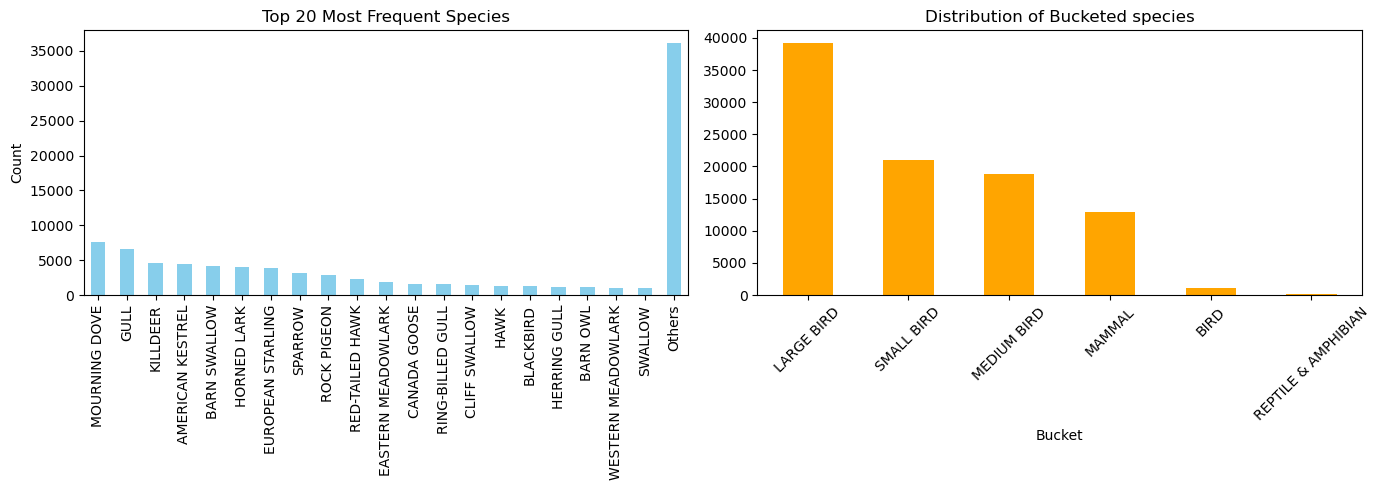

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Top 20 species + Others
species_counts = df['Species Name'].value_counts()
top_species = species_counts.head(20)
other_species = pd.Series(species_counts.iloc[20:].sum(), index=['Others'])
plot_data = pd.concat([top_species, other_species])
plot_data.plot(kind='bar', ax=axs[0], color='skyblue')
axs[0].set_title('Top 20 Most Frequent Species')
axs[0].set_ylabel('Count')
axs[0].tick_params(axis='x', rotation=90)

# Plot 2: Bucket distribution
bucket_counts = df['Bucket'].value_counts()
bucket_counts.plot(kind='bar', ax=axs[1], color='orange')
axs[1].set_title('Distribution of Bucketed species')
axs[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig("Species-Dist.png", dpi=300, bbox_inches='tight')
plt.show()

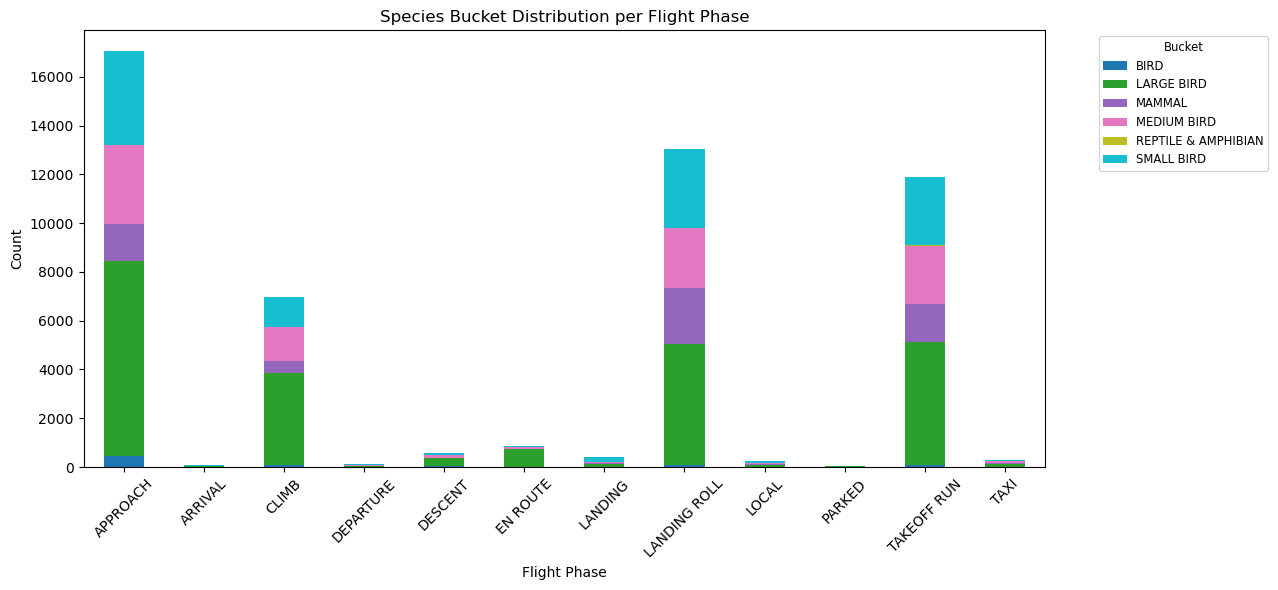

In [11]:
phase_bucket = df.groupby(['Flight Phase', 'Bucket']).size().unstack(fill_value=0)

fig, ax = plt.subplots(figsize=(14, 6))
phase_bucket.plot(kind='bar', stacked=True, ax=ax, colormap='tab10')

ax.set_title('Species Bucket Distribution per Flight Phase')
ax.set_ylabel('Count')
ax.set_xlabel('Flight Phase')
ax.legend( title='Bucket', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', title_fontsize='small')
plt.xticks(rotation=45)
plt.tight_layout()
plt.subplots_adjust(right=0.75)
plt.savefig("image.png", dpi=300, bbox_inches='tight')
plt.show()

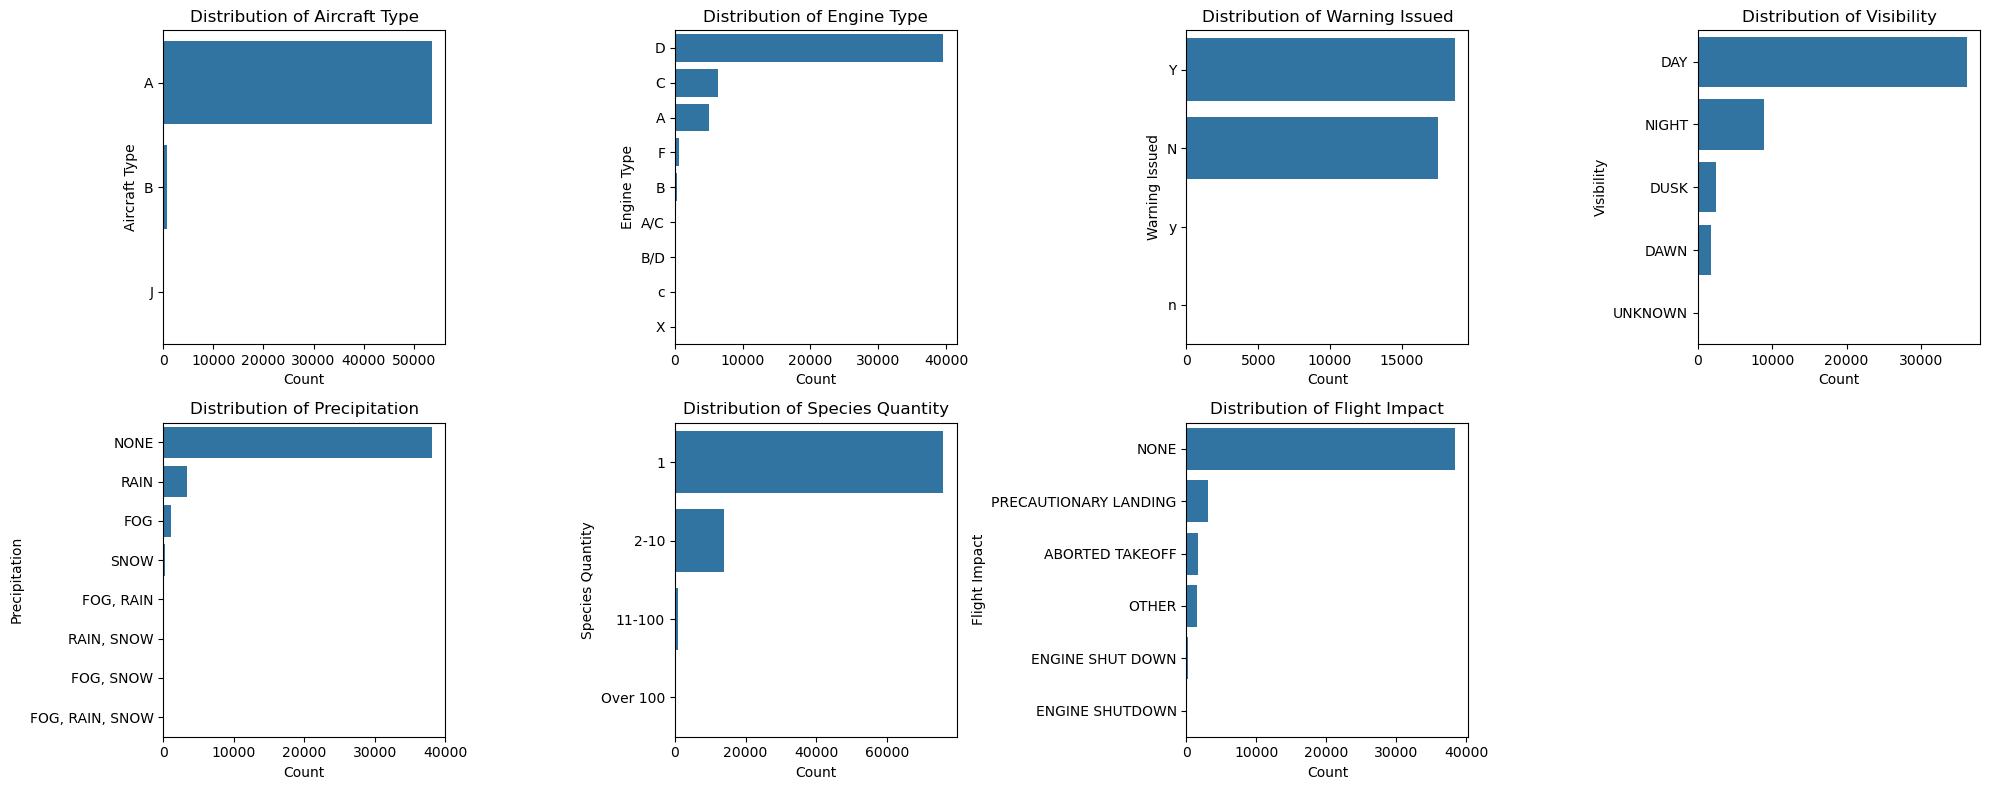

In [12]:
imbalanced_cols = []
for col in categorical_cols:
    value_counts = df[col].value_counts(normalize=True)
    if value_counts.iloc[0] > 0.5:
        imbalanced_cols.append(col)
fig, axes = plt.subplots(2, 4, figsize=(5 * 4, 4 * 2))  
axes = axes.flatten()

for i, col in enumerate(imbalanced_cols):
    value_counts = df[col].value_counts(normalize=True)
    sns.countplot(y=df[col], order=value_counts.index, ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")
    axes[i].set_xlabel("Count")
    axes[i].set_ylabel(col)

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig("image-1.png", dpi=300, bbox_inches='tight')
plt.show()


In [13]:

species_per_state = df.groupby('State')['Species Name'].nunique().reset_index()
species_per_state.columns = ['State', 'Species Count']

fig = px.choropleth(
    species_per_state,
    locations='State',
    locationmode='USA-states',
    color='Species Count',
    color_continuous_scale='Viridis',
    scope='usa',
    title='Distribution of Species Count by US State'
)
fig.show()

CORRELATION

Checking the correlation of variables.

In [ ]:
# Cramér's V function (for categorical vars)
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = stats.chi2_contingency(confusion_matrix, correction=False)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    denom = min((kcorr - 1), (rcorr - 1))
    if denom <= 0:
        return np.nan  
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

categorical_cols = df.select_dtypes(include=['object', 'category']).columns
cramers_matrix = pd.DataFrame(index=categorical_cols, columns=categorical_cols)

for col1 in categorical_cols:
    for col2 in categorical_cols:
        cramers_matrix.loc[col1, col2] = cramers_v(df[col1], df[col2])

cramers_matrix = cramers_matrix.astype(float)

# Numerical correlation matrix 
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
pearson_matrix = df[numerical_cols].corr()


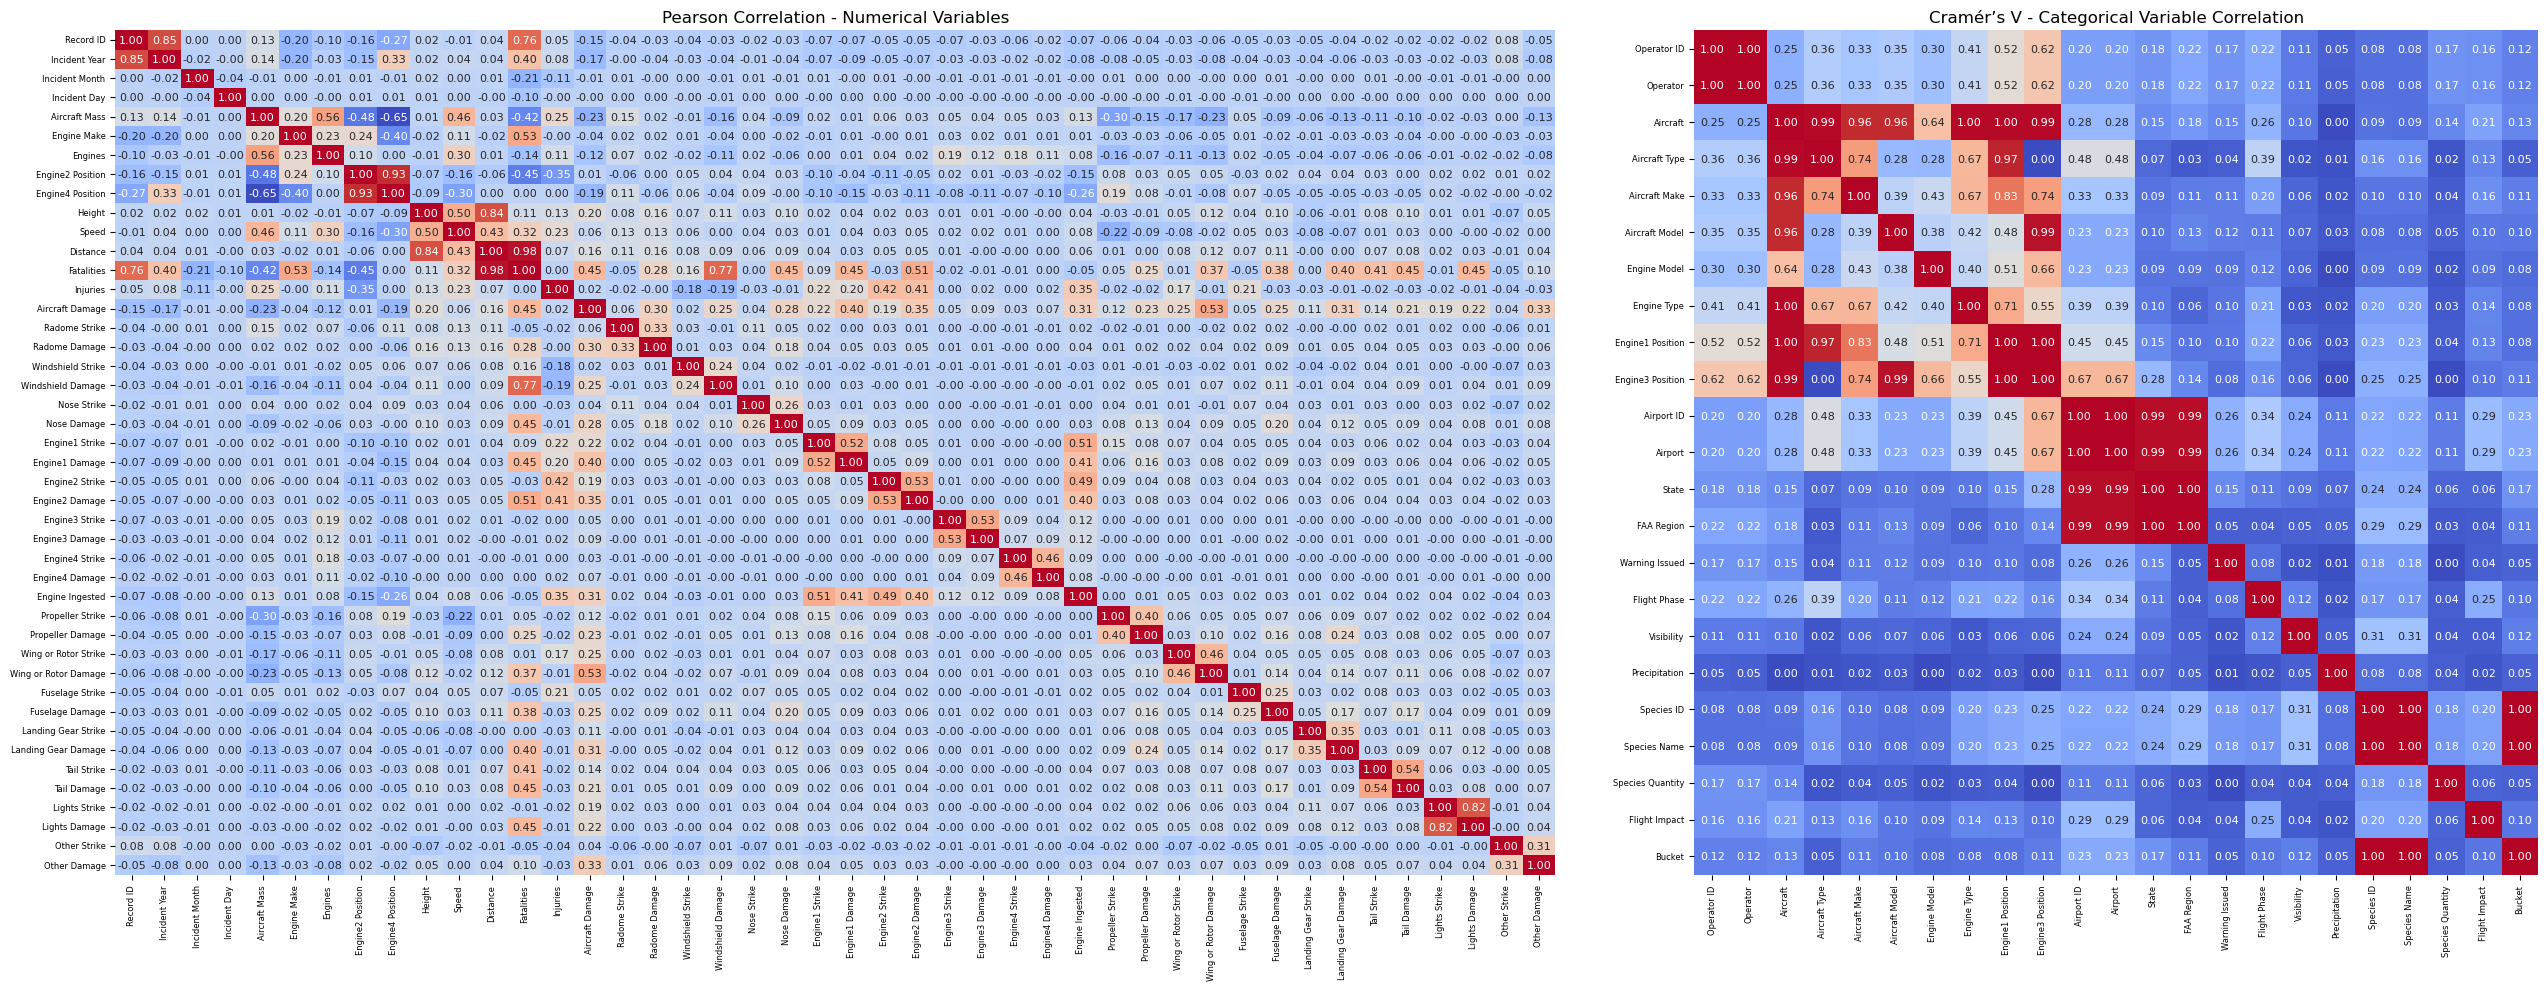

In [ ]:
fig = plt.figure(figsize=(26, 10))  

gs = fig.add_gridspec(1, 5)
ax1 = fig.add_subplot(gs[0, :3])    
ax2 = fig.add_subplot(gs[0, 3:])    

sns.heatmap(
    pearson_matrix.fillna(0).astype(float),
    ax=ax1,
    annot=True,
    cmap='coolwarm',
    square=False,                      
    cbar=False,
    annot_kws={"size": 8},           
    fmt=".2f"
)
ax1.set_title("Pearson Correlation - Numerical Variables")
ax1.tick_params(axis='x', labelsize=6)
ax1.tick_params(axis='y', labelsize=6)

sns.heatmap(
    cramers_matrix.fillna(0).astype(float),
    ax=ax2,
    annot=True,
    cmap='coolwarm',
    square=True,
    cbar=False,
    annot_kws={"size": 8},
    fmt=".2f"
)
ax2.set_title("Cramér’s V - Categorical Variable Correlation")
ax2.tick_params(axis='x', labelsize=6)
ax2.tick_params(axis='y', labelsize=6)

plt.tight_layout()

plt.savefig("image-2.png", dpi=300, bbox_inches='tight')
plt.show()

Dropping correlated columns

In [16]:
upper_pearson = np.triu(pearson_matrix, k=1)
upper_cramers = np.triu(cramers_matrix, k=1)

to_drop_pearson = pearson_matrix.columns[(upper_pearson > 0.5).any(axis=0)]
to_drop_cramers = cramers_matrix.columns[(upper_cramers > 0.5).any(axis=0)]

to_drop = list(set(to_drop_pearson).union(to_drop_cramers))
to_drop.append('Species ID')
to_drop.remove('Bucket')
df = df.drop( to_drop,axis=1)
to_drop

['Speed',
 'Aircraft Make',
 'Operator',
 'Engine3 Damage',
 'Incident Year',
 'Engine2 Damage',
 'Lights Damage',
 'Engine1 Damage',
 'State',
 'Wing or Rotor Damage',
 'Engines',
 'Engine Ingested',
 'Engine Model',
 'Distance',
 'Engine1 Position',
 'Airport',
 'Engine4 Position',
 'Tail Damage',
 'Fatalities',
 'Aircraft Type',
 'FAA Region',
 'Species Name',
 'Engine Type',
 'Aircraft Model',
 'Windshield Damage',
 'Engine3 Position',
 'Airport ID',
 'Species ID']

Spliting train and test

In [17]:
X = df.drop(['Bucket'], axis=1)
y = df['Bucket']
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, stratify=y, random_state=42)


Imputation, Scaling and Encoding pipeline
Using Mode for categorical and Median for the numerical

In [20]:
# Identify column types
numerical_cols = X_train.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, numerical_cols),
    ('cat', cat_pipeline, categorical_cols)
])

# Fit and transform
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Get feature names
encoded_cat_features = preprocessor.named_transformers_['cat']\
    .named_steps['encoder'].get_feature_names_out(categorical_cols)
all_features = numerical_cols + encoded_cat_features.tolist()

# Convert to DataFrames
X_train = pd.DataFrame(X_train_processed, columns=all_features, index=X_train.index)
X_test = pd.DataFrame(X_test_processed, columns=all_features, index=X_test.index)

joblib.dump(preprocessor, 'preprocessor_pipeline.pkl')


/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning:

Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros



['preprocessor_pipeline.pkl']

SMOTE

In [21]:
old_size = X_train.shape
smote = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=5)
X_train, y_train = smote.fit_resample(X_train.astype(float), y_train)
print(f"Before SMOTE it was {old_size} and after SMOTE it is {X_train.shape}. \nSo we have {y_train.unique().size} species each with {y_train.value_counts().iloc[0]} entries in them.")

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning:

`BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.



Before SMOTE it was (74602, 1072) and after SMOTE it is (188250, 1072). 
So we have 6 species each with 31375 entries in them.


In [22]:
def facet_confusion_matrices(train_confusion_matrix, test_confusion_matrix, species_names):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    sns.heatmap(train_confusion_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=species_names, yticklabels=species_names, ax=axes[0])
    axes[0].set_title("Training Confusion Matrix")
    axes[0].set_xlabel("Predicted")
    axes[0].set_ylabel("True")

    sns.heatmap(test_confusion_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=species_names, yticklabels=species_names, ax=axes[1])
    axes[1].set_title("Test Confusion Matrix")
    axes[1].set_xlabel("Predicted")
    axes[1].set_ylabel("True")

    plt.tight_layout()
    plt.show()


In [ ]:
def print_accuracies(model, X_train, y_train, X_test, y_test, model_name,fit_required=True, species_names=None):
    # Fit the model
    model.fit(X_train, y_train)

    # Predict
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Accuracy
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    print(f"Model: {model_name}")
    print(f"Train Accuracy: {train_accuracy:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}\n")

    # Classification reports
    train_report = classification_report(y_train, y_train_pred, target_names=species_names, output_dict=True, zero_division=1)
    test_report = classification_report(y_test, y_test_pred, target_names=species_names, output_dict=True, zero_division=1)

    print("Train Classification Report:\n", pd.DataFrame(train_report).transpose())
    print("\nTest Classification Report:\n", pd.DataFrame(test_report).transpose())

    # Confusion matrices
    train_cm = confusion_matrix(y_train, y_train_pred)
    test_cm = confusion_matrix(y_test, y_test_pred)

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    sns.heatmap(train_cm, annot=True, fmt='d', ax=axes[0], cmap='Blues', xticklabels=species_names, yticklabels=species_names)
    axes[0].set_title('Train Confusion Matrix')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('Actual')

    sns.heatmap(test_cm, annot=True, fmt='d', ax=axes[1], cmap='Greens', xticklabels=species_names, yticklabels=species_names)
    axes[1].set_title('Test Confusion Matrix')
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('Actual')

    plt.tight_layout()
    plt.show()
    
    report = classification_report(y_test, y_test_pred, output_dict=True, zero_division=1)
    df_report = pd.DataFrame(report).transpose()

    
    df_labels = df_report.iloc[:-3]

    
    top_labels = df_labels.sort_values('f1-score', ascending=False).head(20)
    top_labels[['precision', 'recall', 'f1-score']].plot.bar(figsize=(14, 6), title='Metrics sorted by f1 score')

    plt.show()


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Model: LogisticRegression
Train Accuracy: 0.4761
Test Accuracy: 0.2645

Train Classification Report:
                      precision    recall  f1-score        support
BIRD                  0.635819  0.838916  0.723383   31375.000000
LARGE BIRD            0.528718  0.287235  0.372243   31375.000000
MAMMAL                0.394345  0.294247  0.337020   31375.000000
MEDIUM BIRD           0.398416  0.198821  0.265266   31375.000000
REPTILE & AMPHIBIAN   0.440259  0.955378  0.602755   31375.000000
SMALL BIRD            0.390245  0.281785  0.327263   31375.000000
accuracy              0.476064  0.476064  0.476064       0.476064
macro avg             0.464634  0.476064  0.437988  188250.000000
weighted avg          0.464634  0.476064  0.437988  188250.000000

Test Classification Report:
                      precision    recall  f1-score       support
BIRD                  0.071168  0.690265  0.129032    226.000000
LARGE BIRD            0.704298  0.279959  0.400657   7844.000000
MAMMAL       

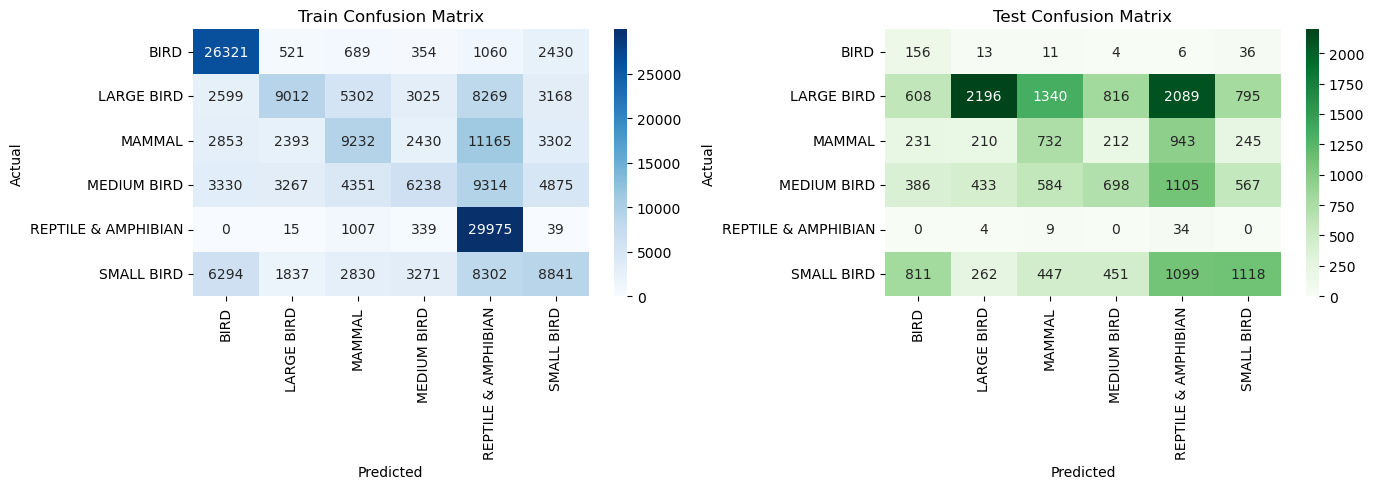

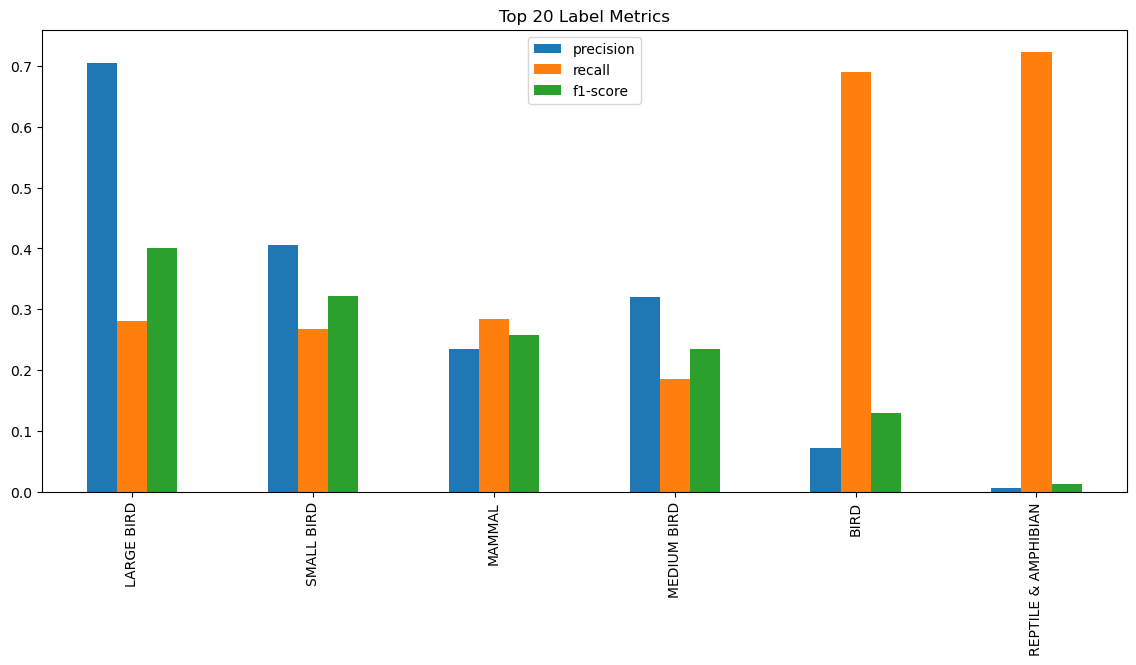

['model_log_no_pcs.pkl']

In [24]:
model_log_no_pcs = LogisticRegression(random_state=42)
print_accuracies(model_log_no_pcs , X_train,y_train,X_test,y_test, "LogisticRegression",  species_names=[str(cls) for cls in np.unique(y_train)]) 
joblib.dump(model_log_no_pcs, 'model_log_no_pcs.pkl')

Model: RandomForestClassifier
Train Accuracy: 0.9999
Test Accuracy: 0.4352

Train Classification Report:
                      precision    recall  f1-score        support
BIRD                  1.000000  1.000000  1.000000   31375.000000
LARGE BIRD            0.999936  0.999777  0.999857   31375.000000
MAMMAL                0.999809  0.999809  0.999809   31375.000000
MEDIUM BIRD           0.999745  0.999841  0.999793   31375.000000
REPTILE & AMPHIBIAN   0.999904  0.999968  0.999936   31375.000000
SMALL BIRD            0.999809  0.999809  0.999809   31375.000000
accuracy              0.999867  0.999867  0.999867       0.999867
macro avg             0.999867  0.999867  0.999867  188250.000000
weighted avg          0.999867  0.999867  0.999867  188250.000000

Test Classification Report:
                      precision    recall  f1-score       support
BIRD                  0.138554  0.101770  0.117347    226.000000
LARGE BIRD            0.554017  0.622387  0.586215   7844.000000
MAMMAL   

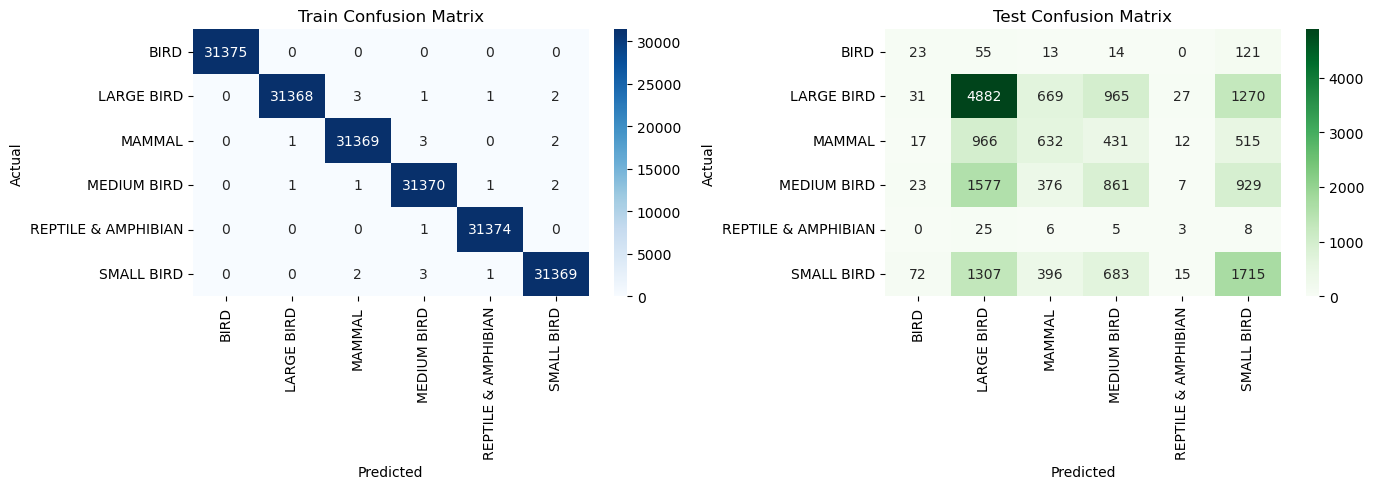

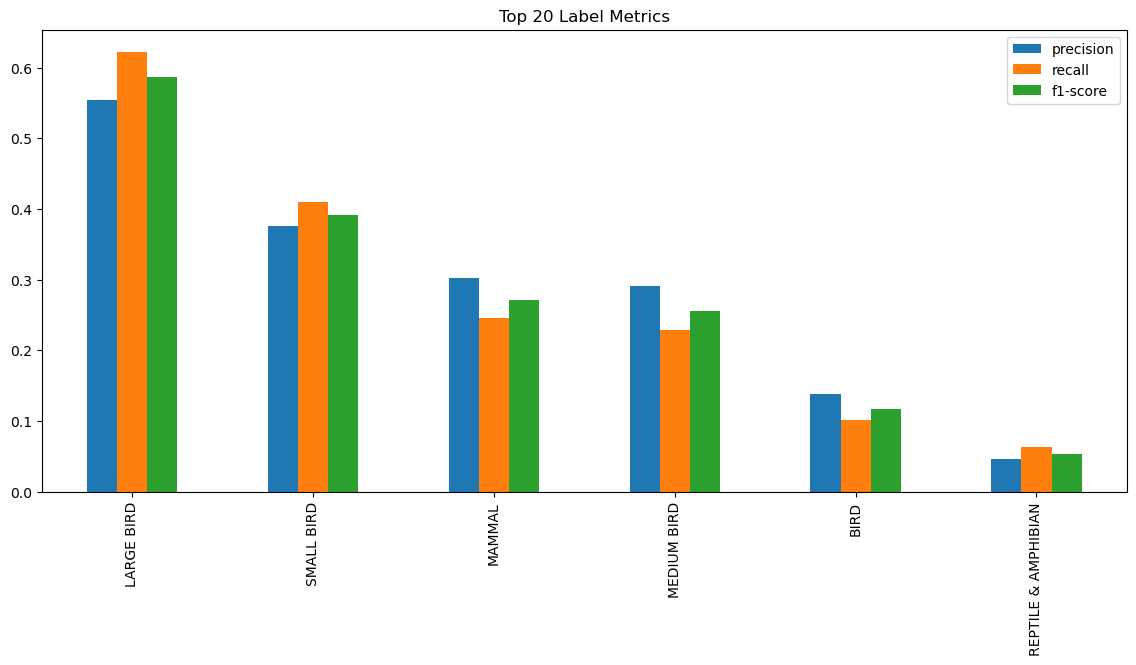

['model_rand.pkl']

In [25]:
model_rand = RandomForestClassifier(random_state=42, class_weight='balanced')
print_accuracies(model_rand , X_train,y_train,X_test,y_test, "RandomForestClassifier", species_names=[str(cls) for cls in np.unique(y_train)]) 
joblib.dump(model_rand, 'model_rand.pkl')

Doing PCA to see changes also adding other parameters since our random forest is over fitting above.

In [26]:
pca = PCA(n_components=0.95)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

Model: RandomForestClassifierwithPCA
Train Accuracy: 0.5593
Test Accuracy: 0.3093

Train Classification Report:
                      precision    recall  f1-score       support
BIRD                  0.620141  0.931506  0.744583   31375.00000
LARGE BIRD            0.527747  0.419506  0.467442   31375.00000
MAMMAL                0.471863  0.453259  0.462374   31375.00000
MEDIUM BIRD           0.536851  0.229610  0.321650   31375.00000
REPTILE & AMPHIBIAN   0.633604  0.982566  0.770411   31375.00000
SMALL BIRD            0.444347  0.339474  0.384895   31375.00000
accuracy              0.559320  0.559320  0.559320       0.55932
macro avg             0.539092  0.559320  0.525226  188250.00000
weighted avg          0.539092  0.559320  0.525226  188250.00000

Test Classification Report:
                      precision    recall  f1-score      support
BIRD                  0.054224  0.650442  0.100102    226.00000
LARGE BIRD            0.627169  0.373151  0.467908   7844.00000
MAMMAL         

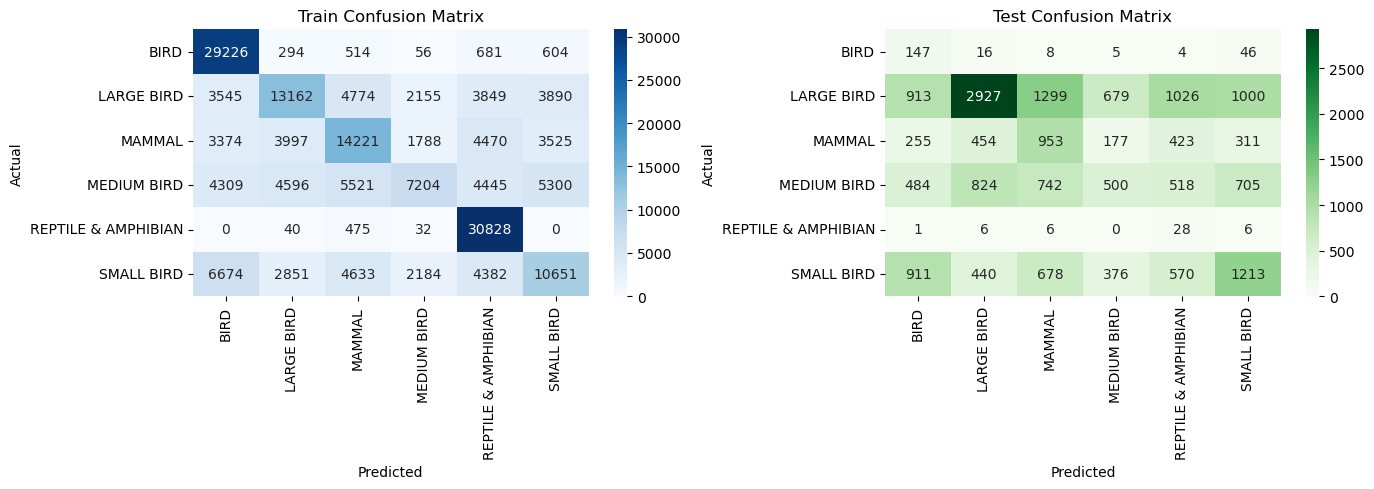

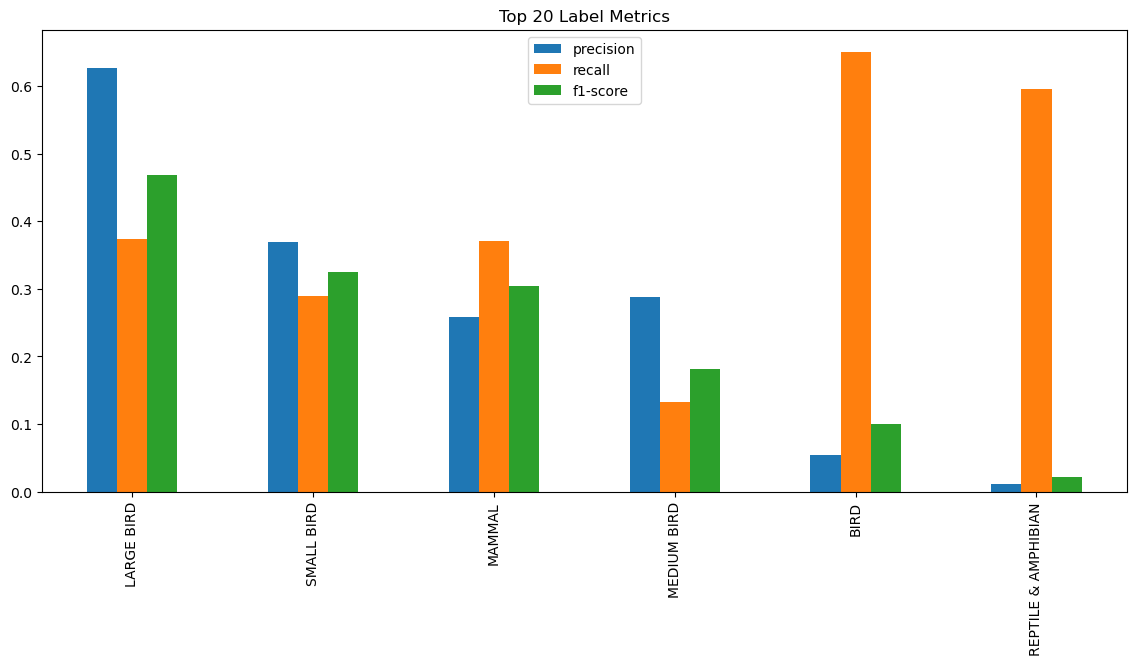

['model_rand_pca.pkl']

In [27]:
model_rand_pca = RandomForestClassifier(         
    n_estimators=200,           
    max_depth=10,               
    min_samples_split=10,       
    min_samples_leaf=4,         
    max_features='sqrt',        
    random_state=42, class_weight='balanced')
print_accuracies(model_rand_pca , X_train,y_train,X_test,y_test, "RandomForestClassifierwithPCA", species_names=[str(cls) for cls in np.unique(y_train)]) 

joblib.dump(pca, 'pca.pkl')
joblib.dump(model_rand_pca, 'model_rand_pca.pkl')

In [28]:
X_sample , _, y_sample, _ = train_test_split(X_train, y_train, train_size=0.05, stratify=y_train)

In [29]:
'''param_grid = {
    'C': [0.1, 3, 5],
    'gamma': [0.01, 0.1, 5],
    'kernel': ['rbf']
}
grid_search = GridSearchCV(SVC(), param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_sample, y_sample)

print("Best parameters:", grid_search.best_params_)
model = grid_search.best_estimator_'''

'param_grid = {\n    \'C\': [0.1, 3, 5],\n    \'gamma\': [0.01, 0.1, 5],\n    \'kernel\': [\'rbf\']\n}\ngrid_search = GridSearchCV(SVC(), param_grid, cv=5, n_jobs=-1)\ngrid_search.fit(X_sample, y_sample)\n\nprint("Best parameters:", grid_search.best_params_)\nmodel = grid_search.best_estimator_'

In [30]:
'''svc_clf = SVC(C=grid_search.best_params_['C'], kernel=grid_search.best_params_['kernel'],
              gamma=grid_search.best_params_['gamma'],class_weight='balanced')  
print_accuracies(svc_clf , X_train,y_train,X_test,y_test, "SVC", species_names=[str(cls) for cls in np.unique(y_train)]) 
joblib.dump(svc_clf, 'SVC_model.pkl')'''

'svc_clf = SVC(C=grid_search.best_params_[\'C\'], kernel=grid_search.best_params_[\'kernel\'],\n              gamma=grid_search.best_params_[\'gamma\'],class_weight=\'balanced\')  \nprint_accuracies(svc_clf , X_train,y_train,X_test,y_test, "SVC", species_names=[str(cls) for cls in np.unique(y_train)]) \njoblib.dump(svc_clf, \'SVC_model.pkl\')'

In [31]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

num_classes=len(np.unique(y_train_encoded))

y_train_onehot = tf.keras.utils.to_categorical(y_train_encoded, num_classes=num_classes)
y_test_onehot = tf.keras.utils.to_categorical(y_test_encoded, num_classes=num_classes)

model = Sequential([
    tf.keras.layers.Input(shape=X_train.shape[1:]),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train_onehot, epochs=50, batch_size=32, validation_split=0.2) 
print_accuracies(model , X_train,y_train_onehot,X_test,y_test_onehot, "Neural Networks",fit_required=False, species_names=[str(cls) for cls in np.unique(y_train)]) 


Epoch 1/50
4707/4707 ━━━━━━━━━━━━━━━━━━━━ 4s 760us/step - accuracy: 0.3562 - loss: 1.6014 - val_accuracy: 0.2748 - val_loss: 1.7938
Epoch 2/50
4707/4707 ━━━━━━━━━━━━━━━━━━━━ 3s 732us/step - accuracy: 0.4350 - loss: 1.3740 - val_accuracy: 0.3822 - val_loss: 1.7144
Epoch 3/50
4707/4707 ━━━━━━━━━━━━━━━━━━━━ 4s 747us/step - accuracy: 0.4509 - loss: 1.3415 - val_accuracy: 0.2247 - val_loss: 1.8258
Epoch 4/50
4707/4707 ━━━━━━━━━━━━━━━━━━━━ 3s 733us/step - accuracy: 0.4570 - loss: 1.3245 - val_accuracy: 0.3724 - val_loss: 1.6448
Epoch 5/50
4707/4707 ━━━━━━━━━━━━━━━━━━━━ 3s 740us/step - accuracy: 0.4630 - loss: 1.3110 - val_accuracy: 0.4548 - val_loss: 1.5712
Epoch 6/50
4707/4707 ━━━━━━━━━━━━━━━━━━━━ 4s 745us/step - accuracy: 0.4636 - loss: 1.3043 - val_accuracy: 0.4133 - val_loss: 1.6235
Epoch 7/50
4707/4707 ━━━━━━━━━━━━━━━━━━━━ 3s 738us/step - accuracy: 0.4658 - loss: 1.2982 - val_accuracy: 0.3474 - val_loss: 1.6617
Epoch 8/50
4707/4707 ━━━━━━━━━━━━━━━━━━━━ 3s 731us/step - accuracy: 0.4676 -

TypeError: print_accuracies() got an unexpected keyword argument 'fit_required'